In [7]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Model 2: Dynamic Pricing Model with Mathematical Demand Function
df = pd.read_csv('dataset.csv')
df.head()

BASE_PRICE = 10.0
df['occupancy_ratio'] = df['Occupancy'] / df['Capacity']
df['Hour'] = pd.to_datetime(df['LastUpdatedTime'], format='%H:%M:%S').dt.hour
df['DayOfWeek'] = pd.to_datetime(df['LastUpdatedDate'], format='%d-%m-%Y').dt.dayofweek

df['TrafficCondition_encoded'] = df['TrafficConditionNearby'].map({'low': 0, 'average': 1, 'high': 2}).fillna(1)
df['VehicleType_encoded'] = df['VehicleType'].map({'car': 0, 'bike': 1, 'cycle': 1, 'truck': 2}).fillna(0)


In [9]:
# Mathematical Demand Function - Complex Dynamic Model
def calculate_demand_factor(occupancy_ratio, queue_length, traffic_level, special_day, vehicle_type, hour, day_of_week):
    
    if pd.isna(occupancy_ratio) or pd.isna(queue_length): return 1.0
    occupancy_ratio = np.clip(occupancy_ratio, 0, 1)
    queue_length = max(0, queue_length)
    
    time_factor = np.sin(hour * np.pi / 12) * 0.2 + 0.8 
    weekend_factor = 1.15 if day_of_week >= 5 else 0.95
    
    occupancy_component = (occupancy_ratio ** 1.5) * 0.6  
    queue_component = (min(queue_length / 12.0, 1.0) ** 1.2) * 0.3 * (1 + traffic_level * 0.15)
    
    vehicle_multipliers = {0: 1.0, 1: 0.7, 2: 1.3}  
    vehicle_adjustment = vehicle_multipliers.get(vehicle_type, 1.0)
    
    special_surge = special_day * 0.25
    traffic_surge = traffic_level * 0.1
    
    # Create natural base variation around 1.0 with slight upward shift
    base_variation = np.random.normal(0.1, 0.05) 
    
    # Combine components naturally with slight upward adjustment
    raw_demand = (0.4 + occupancy_component + queue_component + special_surge + traffic_surge) * vehicle_adjustment * weekend_factor * time_factor + base_variation  # Increased from 0.3 to 0.4
    
    # Use gentler sigmoid for more spread distribution
    sigmoid_input = (raw_demand - 0.7) * 3 
    normalized_demand = 1 / (1 + np.exp(-sigmoid_input))  
    
    demand_factor = 0.5 + 1.4 * normalized_demand  
    
    return np.clip(demand_factor, 0.5, 2.0)  

# Apply demand function and create target price
df['demand_factor'] = df.apply(lambda row: calculate_demand_factor(
    row['occupancy_ratio'], row['QueueLength'], row['TrafficCondition_encoded'],
    row['IsSpecialDay'], row['VehicleType_encoded'], row['Hour'], row['DayOfWeek']
), axis=1)

df['target_price'] = BASE_PRICE * df['demand_factor']
print(f"Price range: ${df['target_price'].min():.2f} - ${df['target_price'].max():.2f}")

# Model training
dynamic_features = ['occupancy_ratio', 'QueueLength', 'TrafficCondition_encoded', 
                   'IsSpecialDay', 'VehicleType_encoded', 'Hour', 'DayOfWeek', 'demand_factor']
X, y = df[dynamic_features], df['target_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params = {'objective': 'regression', 'metric': 'rmse', 'verbose': 0, 'random_state': 42, 
              'num_leaves': 50, 'learning_rate': 0.05, 'feature_fraction': 0.8}
train_data = lgb.Dataset(X_train, label=y_train)
dynamic_model = lgb.train(lgb_params, train_data, num_boost_round=200)

y_pred_test = np.clip(dynamic_model.predict(X_test), BASE_PRICE * 0.6, BASE_PRICE * 2.0) 
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Dynamic Model RMSE: {test_rmse:.4f}")

importance_df = pd.DataFrame({
    'feature': dynamic_features,
    'importance': dynamic_model.feature_importance()
}).sort_values('importance', ascending=False)

Price range: $7.30 - $18.85
Dynamic Model RMSE: 0.0500


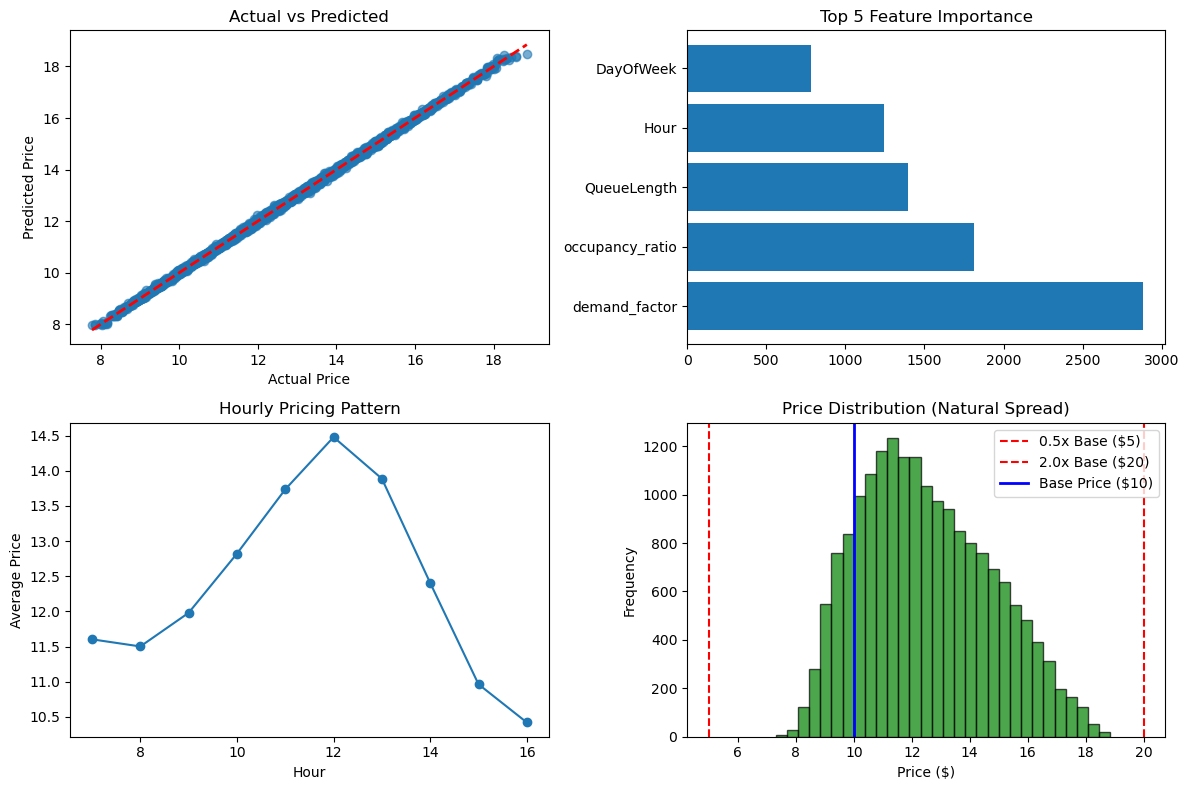

Model Summary - Price Range: $7.30 - $18.85


In [10]:
# Key Visualizations
plt.figure(figsize=(12, 8))

# Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')

# Feature Importance
plt.subplot(2, 2, 2)
plt.barh(importance_df['feature'][:5], importance_df['importance'][:5])
plt.title('Top 5 Feature Importance')

# Hourly Pattern
plt.subplot(2, 2, 3)
hourly_avg = df.groupby('Hour')['target_price'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Hour')
plt.ylabel('Average Price')
plt.title('Hourly Pricing Pattern')

# Price Distribution Histogram
plt.subplot(2, 2, 4)
plt.hist(df['target_price'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=BASE_PRICE * 0.5, color='red', linestyle='--', label='0.5x Base ($5)')
plt.axvline(x=BASE_PRICE * 2.0, color='red', linestyle='--', label='2.0x Base ($20)')
plt.axvline(x=BASE_PRICE, color='blue', linestyle='-', label='Base Price ($10)', linewidth=2)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price Distribution (Natural Spread)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Model Summary - Price Range: ${df['target_price'].min():.2f} - ${df['target_price'].max():.2f}")

In [11]:
# Dynamic Pricing Function
def dynamic_pricing_function(occupancy, capacity, queue_length, traffic_condition, special_day, vehicle_type, hour, day_of_week):
    """Real-time dynamic pricing with complex mathematical demand function"""
    occupancy_ratio = occupancy / capacity
    traffic_encoded = {'Low': 0, 'Medium': 1, 'High': 2}.get(traffic_condition, 1)
    vehicle_encoded = {'car': 0, 'bike': 1, 'truck': 2}.get(vehicle_type, 0)
    
    demand_factor = calculate_demand_factor(occupancy_ratio, queue_length, traffic_encoded, 
                                           int(special_day), vehicle_encoded, hour, day_of_week)
    
    features = np.array([[occupancy_ratio, queue_length, traffic_encoded, int(special_day),
                         vehicle_encoded, hour, day_of_week, demand_factor]])
    
    predicted_price = dynamic_model.predict(features)[0]
    return np.clip(predicted_price, BASE_PRICE * 0.6, BASE_PRICE * 2.0)  

# Test cases with varied pricing scenarios
test_cases = [(20, 100, 0, 'Low', False, 'bike', 9, 1),  
              (60, 100, 3, 'Medium', False, 'car', 14, 3), 
              (85, 100, 8, 'High', False, 'car', 17, 1),  
              (95, 100, 12, 'High', True, 'truck', 19, 6)] 
for i, case in enumerate(test_cases):
    price = dynamic_pricing_function(*case)
    print(f"Case {i+1}: ${price:.2f} | Conditions: {case[0]}/{case[1]} occupancy, {case[2]} queue, {case[3]} traffic")

Case 1: $8.81 | Conditions: 20/100 occupancy, 0 queue, Low traffic
Case 2: $11.82 | Conditions: 60/100 occupancy, 3 queue, Medium traffic
Case 3: $14.52 | Conditions: 85/100 occupancy, 8 queue, High traffic
Case 4: $18.49 | Conditions: 95/100 occupancy, 12 queue, High traffic
